<a id=top-page></a>
# `pykitPIV` demo: Generate synthetic PIV images

In this Jupyter notebook, we show how `pykitPIV` can be used as a synthetic PIV image generator. This notebook shows the full workflow that uses the four classes in a sequence:

`Particle` $\rightarrow$ `FlowField` $\rightarrow$ `Motion` $\rightarrow$ `Image`

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#generate-particles">Generate particles</a></li>
    <li><a href="#generate-velocity-field">Generate random velocity field to advect the particles</a></li>
    <li><a href="#add-movement">Add movement to particles</a></li>
        <ul>
        <li><a href="#add-movement-update-time-sep">Update time separation</a></li>
        <li><a href="#add-movement-visualize">Visualize the PIV image pair</a></li>
        </ul>
    <li><a href="#save">Save the dataset</a></li>
    <li><a href="#upload">Upload the saved datasets</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
import numpy as np
import sys
import cmcrameri.cm as cmc
from pykitPIV import Particle, FlowField, Motion, Image

2025-05-15 16:59:18.397848: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
save_images = False
filename = None

In [3]:
origin = 'lower'

Specify the number of image pairs to generate:

In [4]:
n_images = 2

Define image size in pixels -- this tuple defines the proper PIV image area, in this case $(240 \text{px} \times 500 \text{px})$:

In [5]:
image_size = (240, 500)

Specify the buffer in pixels for the image size:

In [6]:
size_buffer = 10

With a buffer equal to $10 \text{px}$, the total PIV image area in this case is $(260 \text{px} \times 520 \text{px})$.

Buffer should always be added to images to allow particles to exit or enter the proper PIV image area without creating
spurious disappearance of particles close to image edge. At any stage of plotting or saving PIV images, the user can decide to
visualize/save with buffer (``with_buffer=True``) or without buffer (``with_buffer=False``). When ``with_buffer=True``,
the buffer outline is marked with the red rectangle on plots.

Specify the figure sizes for all plotted images:

In [7]:
figsize = (6,3.5)

By setting the `dtype` parameter, the user can steer the floating-point arithmetics. The default is `np.float64` but no significant loss of precision in image intensities and flow targets can be seen for `np.float32`.

In [8]:
dtype = np.float32

You can always check the size in memory of a variable by calling `sys.getsizeof(variable)`.

<a id=generate-particles></a>
***

## Generate particles

[Go to the top](#top-page)

Instantiate an object of the ``Particle`` class that defines particles with specific properties, and seed the particles randomly:


In [9]:
particles = Particle(n_images, 
                     size=image_size, 
                     size_buffer=size_buffer,
                     diameters=(2,4),
                     distances=(1,2),
                     densities=(0.05,0.06),
                     diameter_std=(0.5, 0.5),
                     seeding_mode='random', 
                     dtype=dtype,
                     random_seed=100)

Instantiate an object of the ``Image`` class that defines the image space:

In [10]:
image = Image(dtype=dtype,
              random_seed=100)

Add generated particles to the image:

In [11]:
image.add_particles(particles)

If we plot the image at this stage, we will only see the particle locations (attached to pixel centroids):


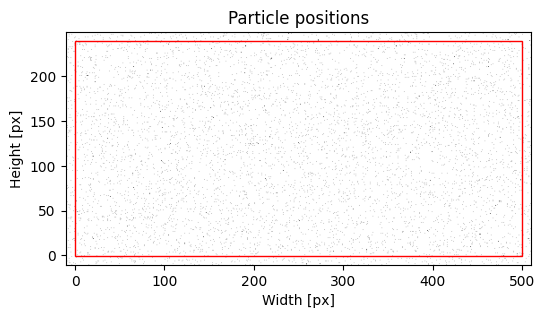

In [12]:
if save_images: filename = 'particle-positions.png'
image.plot(0, 
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Particle positions',
           cmap='Greys',
           origin=origin,
           figsize=figsize, 
           filename=filename);

We can now add laser light reflected from the particles:

In [13]:
image.add_reflected_light(exposures=(0.6,0.95),
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/20)

Which produces the PIV image $I_1$:

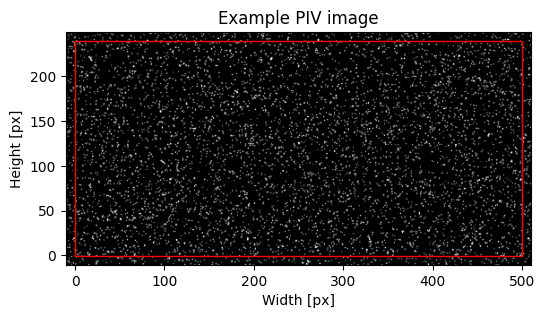

In [14]:
if save_images: filename = 'example-image.png'
image.plot(0, 
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example PIV image',
           cmap='Greys_r',
           origin=origin,
           figsize=figsize, 
           filename=filename);

<a id=generate-velocity-field></a>
***

## Generate random velocity field to advect the particles

[Go to the top](#top-page)

Instantiate an object of the ``FlowField`` class:


In [15]:
flowfield = FlowField(n_images,
                      size=image_size,
                      size_buffer=size_buffer,
                      time_separation=1,
                      dtype=dtype,
                      random_seed=100)

We can print the available velocity fields:

In [16]:
flowfield.print_available_fields()

Velocity fields available in pykitPIV:

- constant
	Use function: generate_constant_velocity_field

- random smooth
	Use function: generate_random_velocity_field

- sinusoidal
	Use function: generate_sinusoidal_velocity_field

- checkered
	Use function: generate_checkered_velocity_field

- Chebyshev polynomials
	Use function: generate_chebyshev_velocity_field

- spherical harmonics
	Use function: generate_spherical_harmonics_velocity_field

- radial
	Use function: generate_radial_velocity_field

- potential
	Use function: generate_potential_velocity_field

- Langevin
	Use function: generate_langevin_velocity_field



and generate the random velocity field:

In [17]:
flowfield.generate_random_velocity_field(gaussian_filters=(10,11),
                                         n_gaussian_filter_iter=20,
                                         displacement=(0,10))

At this point, the displacement field, $d \vec{\mathbf{s}}$, and the displacement field magnitude, $|d \vec{\mathbf{s}}|$, can also be computed:

In [18]:
flowfield.compute_displacement_field()

Add generated flow field to the image:

In [19]:
image.add_flowfield(flowfield)

At this point, the ``Image`` class can help us visualize the generated velocity field.

We can visualize each velocity component:

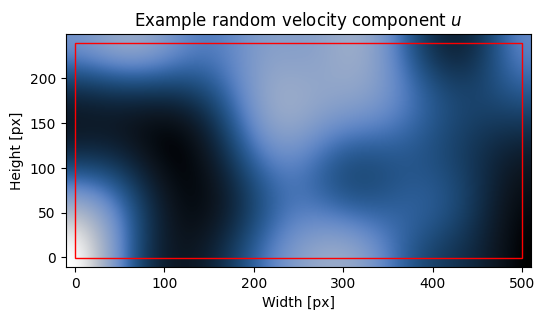

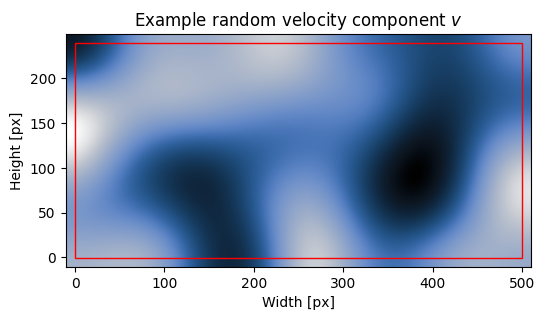

In [20]:
if save_images: filename = 'example-random-velocity-field.png'
image.plot_field(0,
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 title=('Example random velocity component $u$', 'Example random velocity component $v$'),
                 cmap=cmc.oslo_r,
                 origin=origin,
                 figsize=figsize,
                 filename=filename);

We can also visualize the velocity magnitude:

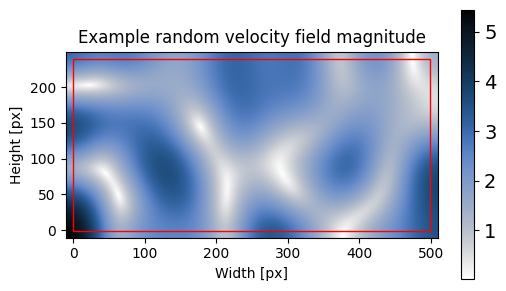

In [21]:
if save_images: filename = 'example-random-velocity-field-magnitude.png'
image.plot_field_magnitude(0,
                           with_buffer=True,
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title='Example random velocity field magnitude',
                           cmap=cmc.oslo_r,
                           figsize=figsize,
                           filename=filename);

Optionally, a quiver plot or a streamplot can be added on top of the velocity magnitude field:


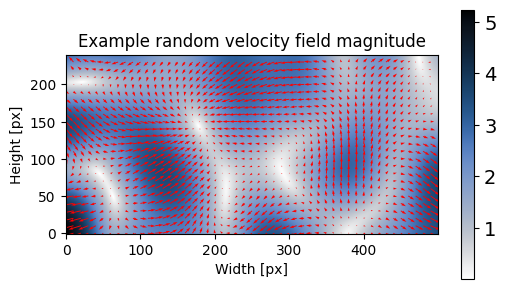

In [22]:
if save_images: filename = 'example-random-velocity-field-magnitude-quiver.png'
image.plot_field_magnitude(0,
                           with_buffer=False,
                           add_quiver=True,
                           quiver_step=10,
                           quiver_color='r',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title='Example random velocity field magnitude',
                           cmap=cmc.oslo_r,
                           figsize=figsize,
                           filename=filename);

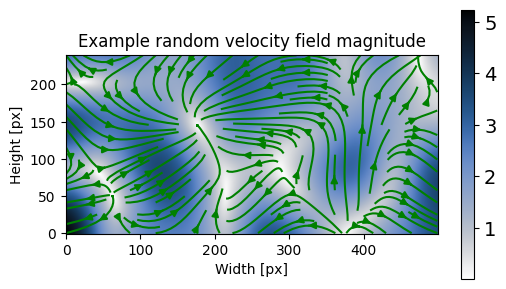

In [23]:
if save_images: filename = 'example-random-velocity-field-magnitude-streamplot.png'
image.plot_field_magnitude(0,
                           with_buffer=False,
                           add_streamplot=True,
                           streamplot_density=1,
                           streamplot_color='g',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title='Example random velocity field magnitude',
                           cmap=cmc.oslo_r,
                           figsize=figsize,
                           filename=filename);

<a id=add-movement></a>
***

## Add movement to particles

[Go to the top](#top-page)

The class ``Motion`` can be used to combine ``Particle`` and ``FlowField`` objects and advect the particles.

Instantiate an object of the ``Motion`` class that takes in the defined particles and the defined flow field:


In [24]:
motion = Motion(particles, 
                flowfield, 
                dtype=dtype)

We now use the forward Euler numerical scheme to advect the particles:


In [25]:
motion.forward_euler(n_steps=10)

After particles have been moved, we can visualize their old vs. new coordinates:


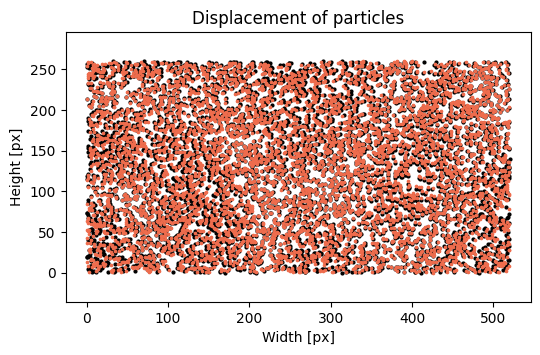

In [26]:
if save_images: filename = 'particle-displacement-1.png'
motion.plot_particle_motion(0,
                            s=4,
                            xlabel='Width [px]',
                            ylabel='Height [px]',
                            title='Displacement of particles',
                            figsize=figsize,
                            filename=filename);

<a id=add-movement-update-time-sep></a>

#### Update time separation:

[Go to the top](#top-page)

Note, that time separation, $\Delta t$, can be updated within the ``FlowField`` class object:


In [27]:
flowfield.time_separation = 2

New displacement can be re-computed for the new time separation:

In [28]:
motion = Motion(particles, 
                flowfield, 
                dtype=dtype)

In [29]:
motion.forward_euler(n_steps=10)

The effect of allowing longer $\Delta t$ can be seen in the figure below:


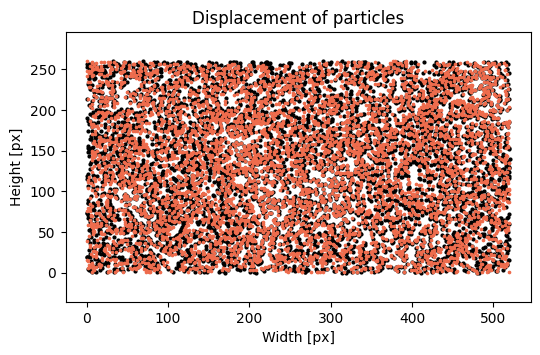

In [30]:
if save_images: filename = 'particle-displacement-2.png'
motion.plot_particle_motion(0,
                            s=4,
                            xlabel='Width [px]',
                            ylabel='Height [px]',
                            title='Displacement of particles',
                            figsize=figsize,
                            filename=filename);

We can also use the 4th order Runge-Kutta scheme:

In [31]:
motion.runge_kutta_4th(n_steps=10)

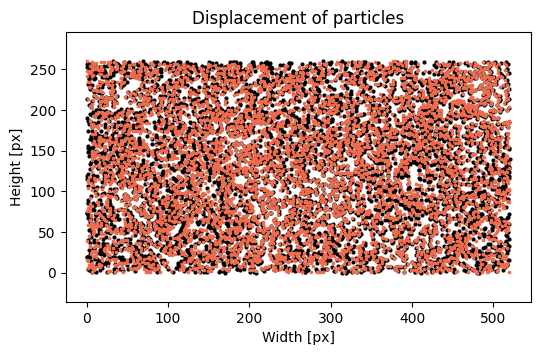

In [32]:
if save_images: filename = 'particle-displacement-RK4.png'
motion.plot_particle_motion(0,
                            s=4,
                            xlabel='Width [px]',
                            ylabel='Height [px]',
                            title='Displacement of particles',
                            figsize=figsize,
                            filename=filename);

<a id=add-movement-visualize></a>

#### Visualize the PIV image pair:

[Go to the top](#top-page)

We add generated motion to the image:

In [33]:
image.add_motion(motion)

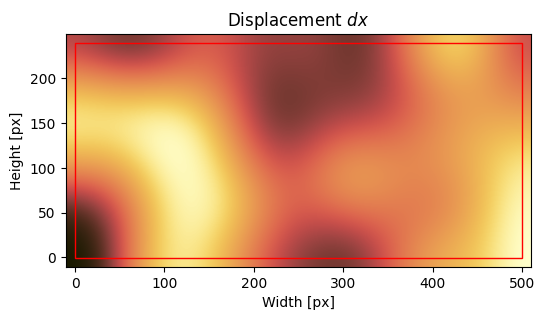

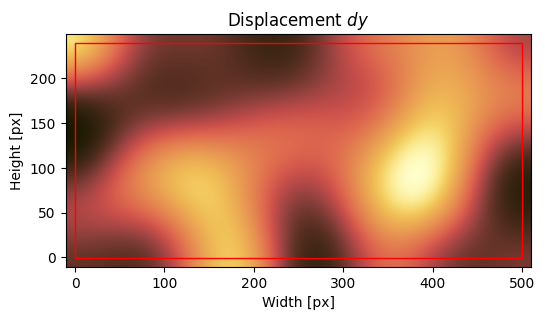

In [34]:
if save_images: filename = 'displacement-field.png'
image.plot_field(0,
                 field='displacement',
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 title=('Displacement $dx$', 'Displacement $dy$'),
                 cmap=cmc.lajolla,
                 origin=origin,
                 figsize=figsize,
                 filename=filename);

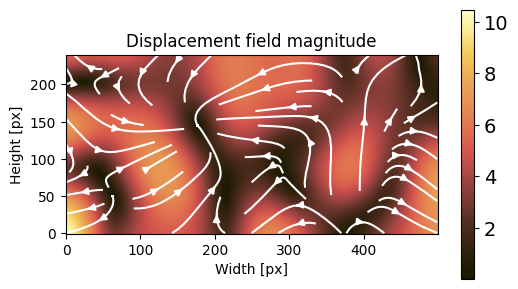

In [35]:
if save_images: filename = 'displacement-field-magnitude.png'
image.plot_field_magnitude(0,
                           field='displacement',
                           with_buffer=False,
                           add_streamplot=True,
                           streamplot_density=0.5,
                           streamplot_color='w',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title='Displacement field magnitude',
                           cmap=cmc.lajolla,
                           figsize=figsize,
                           filename=filename);

We generate the light reflected from each image pair $(I_1, I_2)$:

In [36]:
image.add_reflected_light(exposures=(0.6,0.65),
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/10)

We can view the generated PIV image pair in a static mode:

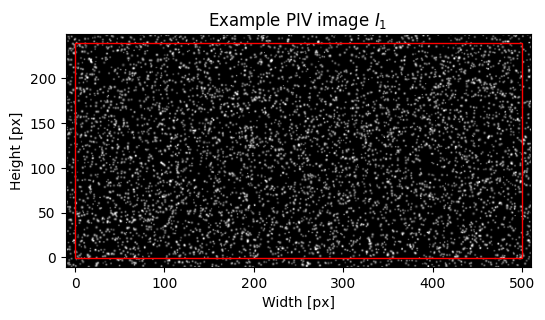

In [37]:
if save_images: filename = 'example-image-I1-with-buffer.png'
image.plot(0, 
           instance=1,
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example PIV image $I_1$',
           cmap='Greys_r',
           origin=origin,
           figsize=figsize, 
           filename=filename);

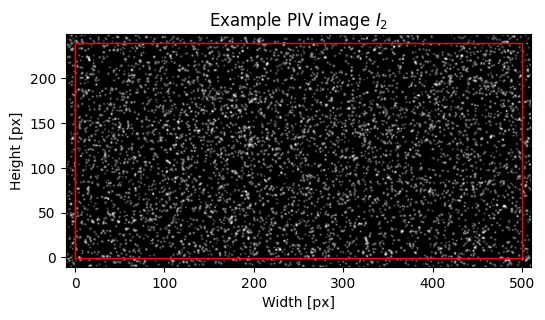

In [38]:
if save_images: filename = 'example-image-I2-with-buffer.png'
image.plot(0, 
           instance=2,
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example PIV image $I_2$',
           cmap='Greys_r',
           origin=origin,
           figsize=figsize, 
           filename=filename);

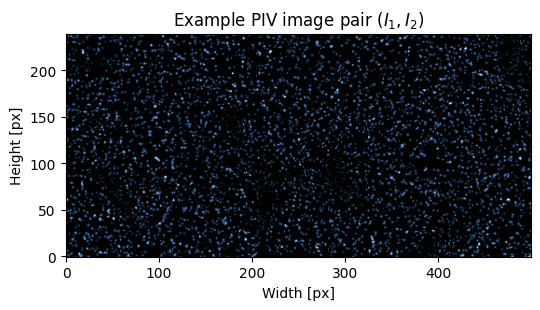

In [39]:
if save_images: filename = 'example-image-I1-I2-no-buffer.png'
image.plot_image_pair(0,
                      with_buffer=False, 
                      xlabel='Width [px]',
                      ylabel='Height [px]',
                      title='Example PIV image pair $(I_1, I_2)$',
                      cmap=cmc.oslo,
                      origin=origin,
                      figsize=figsize, 
                      dpi=600,
                      filename=filename);

as well as in the dynamic mode (as animation):

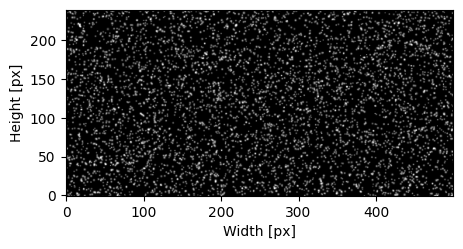

In [40]:
if save_images: filename = 'animated-images.gif'
image.animate_image_pair(0, 
                         with_buffer=False, 
                         xlabel='Width [px]',
                         ylabel='Height [px]',
                         title=None, 
                         cmap='Greys_r', 
                         origin=origin,
                         figsize=(5, 5), 
                         dpi=300, 
                         filename=filename);

<a id=save></a>
***

## Save the dataset

[Go to the top](#top-page)

Note, that at the last stage of the PIV image generation we may want to remove buffers from the images and the associated flow targets by running the `Image.remove_buffers()` function:

In [41]:
images_I1 = image.remove_buffers(image.images_I1)
images_I2 = image.remove_buffers(image.images_I2)

In [42]:
velocity_field = image.remove_buffers(image.get_velocity_field())
displacement_field = image.remove_buffers(image.get_displacement_field())

In [43]:
images_intensities = image.concatenate_tensors((images_I1, images_I2))

In [44]:
flow_targets = image.concatenate_tensors((velocity_field, displacement_field))

We can now save the prepared image pairs and the associated targets to ``.h5`` format.
The saving function requires us to construct a dictionary with tensors to save. In this case, these will be:

In [45]:
tensors_dictionary = {"I"      : images_intensities, 
                      "target" : flow_targets}

In [46]:
image.save_to_h5(tensors_dictionary, 
                 filename='pykitPIV-tutorial-PIV-pairs.h5')

<a id=upload></a>
***

## Upload the saved dataset

[Go to the top](#top-page)

The standalone import of previously saved PIV image pairs and the associated targets can be performed following this minimal example:

In [47]:
from pykitPIV import Image

In [48]:
image = Image()

In [49]:
tensors_dictionary_uploaded = image.upload_from_h5(filename='pykitPIV-tutorial-PIV-pairs.h5')

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)